In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Callable, Optional

In [2]:
# 하이퍼 파라미터
# main_path = '/Users/jaewone/Downloads/floor_noise/sensor_data'
main_path = "/Users/jaewone/Downloads/define_floor_noise/7. 실제 데이터 분석 및 CNN 모델 생성"

window_size = 128

In [3]:
origin_data_path = os.path.join(main_path, 'new_origin_data')
dataset_path = os.path.join(main_path, 'final_dataset')
noise_path = os.path.join(dataset_path, 'noise')
white_path = os.path.join(dataset_path, 'white')

for dir in [dataset_path, noise_path, white_path]:
    if not os.path.exists(dir):
        os.makedirs(dir)


def iter_txt_files(path):
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".txt"):
                yield os.path.join(root, file)

In [4]:
# 모든 파일에 존재하는 노이즈 데이터를 찾아서 하나의 배열로 결합한다.
def find_interfloor_noise_data(file_path, window_size=128, threshold=None):
    df = pd.read_csv(file_path, header=None, names=['x', 'y', 'z'])

    delta_df = df.diff().iloc[1:].abs()

    if threshold is None:
        threshold = delta_df.iloc[:, 2].mean()

    noise_windows = []

    for start_index in range(0, len(delta_df) - window_size + 1, window_size):
        # Select the window
        window = delta_df.iloc[start_index:start_index + window_size, 2]

        if (window > threshold).any():
            noise_windows.append(
                df.iloc[start_index:start_index + window_size].values)

    noise_windows_array = np.array(noise_windows)

    return noise_windows_array


all_noise_windows = np.concatenate([find_interfloor_noise_data(file, window_size)
                                    for file in iter_txt_files(origin_data_path)])
all_noise_windows.shape

(2581, 128, 3)

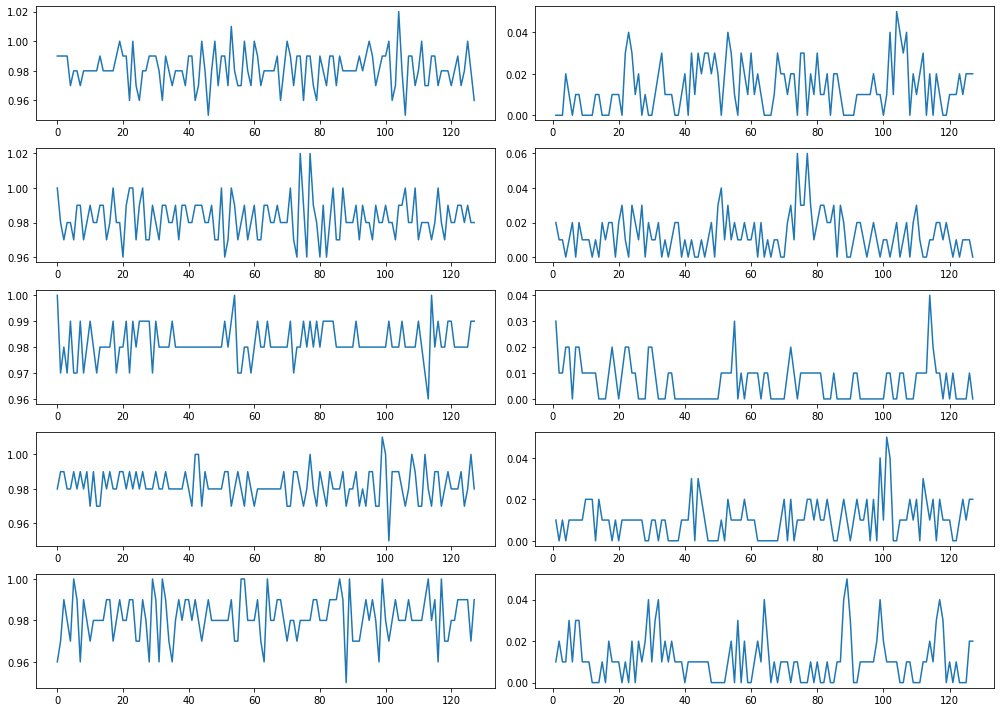

In [5]:
# 그래프로 일부 결과를 확인해보자.
def show_interfloor_noise_data(noise_windows_data, render_graph_count=5):
    graph_count = render_graph_count if noise_windows_data.shape[
        0] > render_graph_count else noise_windows_data.shape[0]

    plt.subplots(graph_count, 2, figsize=(14, 2*graph_count))
    for i in range(graph_count):
        plt.subplot(graph_count, 2, i*2+1)
        plt.plot(noise_windows_data[i, :, 2])
        plt.subplot(graph_count, 2, i*2 + 2)
        plt.plot(pd.DataFrame(
            noise_windows_data[i]).diff().iloc[1:].abs().iloc[:, 2])
    plt.tight_layout()
    plt.show()


show_interfloor_noise_data(all_noise_windows)

In [6]:
# CSV 파일로 저장
import pandas as pd

for i, window in enumerate(all_noise_windows):
    df = pd.DataFrame(window, columns=['x', 'y', 'z'])
    df.to_csv(os.path.join(noise_path, f'noise_{i}.csv'), index=False)

In [7]:
# 빈 데이터셋을 노이즈 데이터셋에 맞추어 증감
# white_data = '/Users/jaewone/Downloads/floor_noise/sensor_data/white_data.txt'
# white_data = '/Users/jaewone/Downloads/floor_noise/test_sample_data.txt'
white_data = "/Users/jaewone/Downloads/define_floor_noise/7. 실제 데이터 분석 및 CNN 모델 생성/white_data.txt"

df = pd.read_csv(white_data, header=None, names=['x', 'y', 'z'])

for i in range(len(os.listdir(noise_path))):
    df.sample(n=128).to_csv(os.path.join(
        white_path, f'white_{i+1}.csv'), index=False)

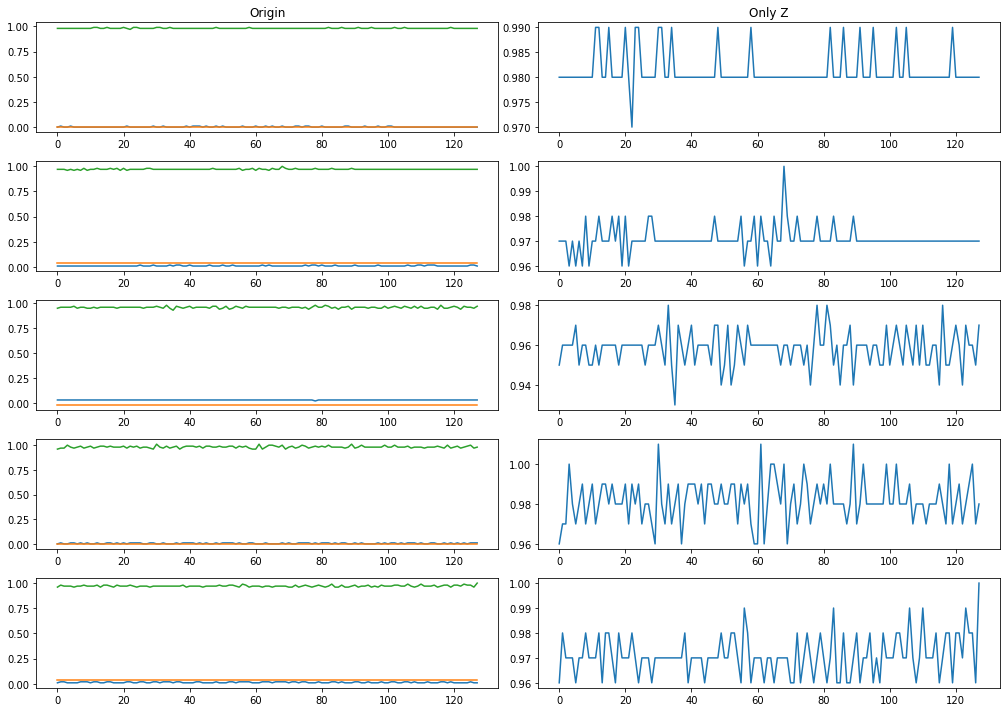

In [8]:
# 생성된 Noise 데이터를 살펴보자.
def show_compared_gyro(file_list, render_graph_count=5):
    graph_count = render_graph_count if len(
        file_list) > render_graph_count else len(file_list)

    plt.subplots(graph_count, 2, figsize=(14, 2*graph_count))
    for i in range(graph_count):
        if (file_list[i].endswith('.csv')):
            data = pd.read_csv(file_list[i])
        else:
            data = pd.read_csv(
                file_list[i], header=None, names=['x', 'y', 'z'])

        plt.subplot(graph_count, 2, i*2+1)
        if i == 0:
            plt.title("Origin")
        plt.plot(data)

        plt.subplot(graph_count, 2, i*2 + 2)
        if i == 0:
            plt.title("Only Z")
        plt.plot(data.iloc[:, 2])
    plt.tight_layout()
    plt.show()


show_compared_gyro(random.choices(
    [os.path.join(noise_path, file)for file in os.listdir(noise_path)], k=5))

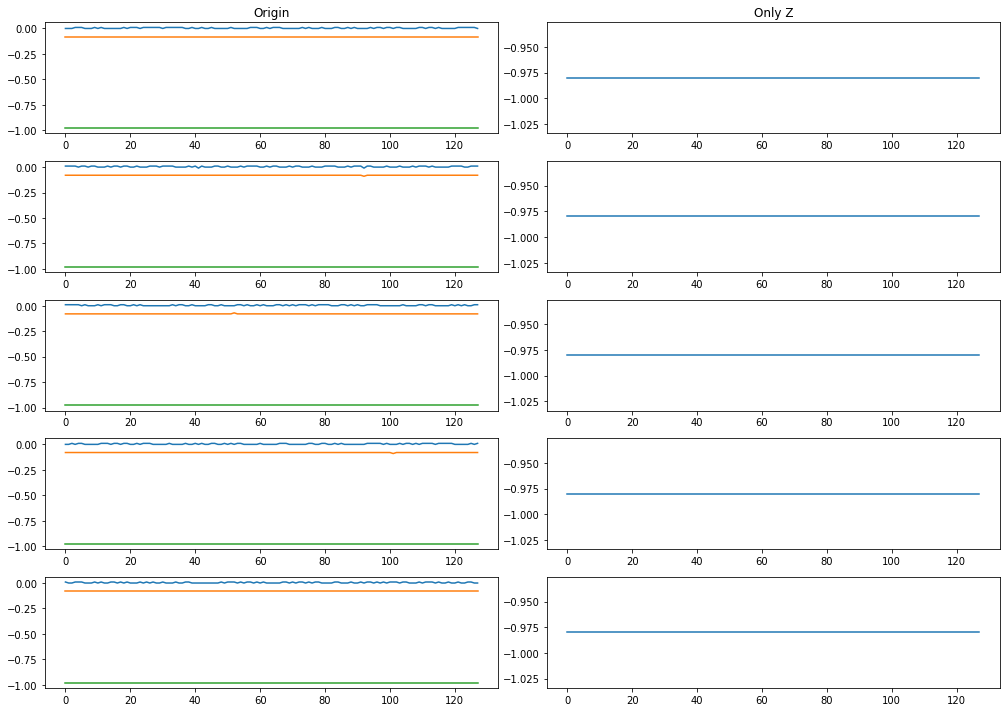

In [9]:
# 생성된 White 데이터를 살펴보자.
show_compared_gyro(random.choices(
    [os.path.join(white_path, file)for file in os.listdir(white_path)], k=5))